In [ ]:
from ltm.features import load_multi_band_raster, drop_nan
import numpy as np

y_path = "../data/processed/y.tif"

y, _ = load_multi_band_raster(y_path)

y = drop_nan(y)

y_pred = y.copy() + np.random.random(y.shape) * 0.1

In [ ]:
from sklearn.metrics import make_scorer, median_absolute_error, mean_squared_error
from sklearn.metrics._scorer import _BaseScorer

def area2mixture_scorer(scorer: _BaseScorer) -> _BaseScorer:
    score_func = scorer._score_func

    def mixture_score_func(y_true: np.ndarray, y_pred: np.ndarray, *args, **kwargs) -> Callable:
        y_true = y_true[:, 0] / (y_true[:, 0] + y_true[:, 1])  # broadleaf is 0, conifer is 1
        y_pred = y_pred[:, 0] / (y_pred[:, 0] + y_pred[:, 1])

        return score_func(y_true, y_pred, *args, **kwargs)
    
    scorer._score_func = mixture_score_func

    return scorer

mae_scorer = make_scorer(median_absolute_error, greater_is_better=False)
mae_scorer = area2mixture_scorer(mae_scorer)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scorer = area2mixture_scorer(mse_scorer)

In [ ]:


_BaseScorer(len, 1, dict())

In [ ]:
help(mse_scorer)


In [ ]:
mae_scorer._score_func(y, y_pred), mse_scorer._score_func(y, y_pred)

# Legit Stuff

In [ ]:
# Create composite images from plot and Sentinel-2 data
from ltm.data import sentinel_composite
import pandas as pd

plot = pd.read_csv("../data/processed/plot.csv")

X_path, y_path = sentinel_composite(
    plot=plot,
    time_window=("2015-07-01", "2016-06-30"),
    num_composites=6,
    level_2a=False,
    temporal_reducers=["min", "max", "median", "variance", "mean", "skew"],
    indices=["NDVI", "NDWI"],
    # sentinel_bands=["B2", "B3", "B4"],
    areas_as_y=True,
)

In [ ]:
# Optional: Interpolate missing values in X, save it as a new raster and visualize
from ltm.data import show_timeseries
from ltm.features import load_multi_band_raster, interpolate_X_and_bands, save_raster

# Define paths and parameters
X_path = "../data/processed/X.tif"
interpolated_X_path = "../data/processed/interpolated_X.tif"
visualized_reducer = "min"
rgb_bands = ["B4", "B3", "B2"]

# Load, interpolate and save new X
X, band_names = load_multi_band_raster(X_path)
interpolated_X, band_names = interpolate_X_and_bands(X, band_names)
save_raster(interpolated_X, band_names, X_path, interpolated_X_path)

# Visualize
show_timeseries(interpolated_X_path, visualized_reducer, rgb_bands=rgb_bands)

In [1]:
# Load and preprocess data
from ltm.features import load_multi_band_raster, interpolate_X_and_bands, drop_nan, get_similarity_matrix, show_similarity_matrix, show_dendrogram, dendrogram_dim_red, permutation_dim_red
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, mean_squared_error)
import matplotlib.pyplot as plt
plt.style.use("ltm.mplstyle")

# Load data
X_path = "../data/processed/interpolated_X.tif"
y_path = "../data/processed/y.tif"

X, band_names = load_multi_band_raster(X_path)
y, _ = load_multi_band_raster(y_path)

# Prevent warnings for single band y
if y.shape[1] == 1:
    y = y.ravel()

# Drop NaN, dim red, split data
X, y = drop_nan(X, y) # TODO time series imputation (e.g. linear interpolation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # stratified is not really possible, unless every band is binned...

# Scale data for non-tree models
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

# Show similarity matrix along with dendrogram
similarity = get_similarity_matrix(X_train, band_names, "pearson")
sm_ax = show_similarity_matrix(similarity)
ddg_ax = show_dendrogram(similarity)

In [ ]:
# Dim red based on dendrogram with threshold
threshold = 1.0

X_train, band_names = dendrogram_dim_red(X_train, band_names, similarity, threshold=threshold)
X_test = X_test[:, [band_names.index(b) for b in band_names]]

In [ ]:
# Dim red based on 
scoring = make_scorer(mean_squared_error, greater_is_better=False)
X_train = X_train
y_train = y_train
X_train, band_names = permutation_dim_red(X_train, band_names, y_train, threshold=0.001, scoring=scoring)

In [2]:
# Train models
from skelm import ELMRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import (make_scorer, max_error, mean_squared_error,
                             median_absolute_error, r2_score)
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBRegressor
from ltm.models import hyperparam_search, best_scores, area2mixture_scorer

# Define the models and hyperparameter search space with distributions: expon, gamma, uniform, loguniform or randint
search_space = {
    # ELMRegressor(): {
    #     "alpha": loguniform(1e-8, 1e5),
    #     "include_original_features": [True, False],
    #     "n_neurons": loguniform(1, 100-1),
    #     "ufunc": ["tanh", "sigm", "relu", "lin"],
    #     "density": uniform(0.01, 0.99),
    # },
    # XGBRegressor(): {
    #     "n_estimators": randint(10, 100-10),
    #     "max_depth": randint(1, 20),
    #     "learning_rate": uniform(0.01, 0.5),
    #     "gamma": uniform(0, 0.5),
    #     "min_child_weight": randint(1, 11),
    # },
    RandomForestRegressor(): {
        "n_estimators": randint(1, 100-1),
        "max_depth": randint(1, 20),
        "max_features": randint(1, 11),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 11),
        "bootstrap": [True, False],
        "criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    },
    # ExtraTreesRegressor(): {
    #     "n_estimators": randint(1, 100-1),
    #     "min_impurity_decrease": loguniform(1e-5, 0.5),
    #     "criterion": ["squared_error", "absolute_error"],
    # },
}

# Define the scorers and refit (scorer for best model selection)
scoring = {"median_absolute_error": make_scorer(median_absolute_error,
                                                greater_is_better=False),
           "mean_squared_error": make_scorer(mean_squared_error,
                                             greater_is_better=False),
           "coefficient of determination": make_scorer(r2_score,
                                   greater_is_better=False),}
refit = "mean_squared_error"

# Modify scorer incase area labels are used
if len(y.shape) == 2:
    scoring = {scorer_name: area2mixture_scorer(scorer) for scorer_name, scorer in scoring.items()}

search_results = hyperparam_search(
    X_train,
    y_train,
    search_space,
    scoring,
    refit,
    kfold_from_endmembers=True,
    kfold_n_splits=5,
    kfold_n_iter=10,
    random_state=0,
)

# Serialize object
import dill as pickle # Necessary to serialize lambda functions

with open("search_results.pkl", "wb") as f:
    pickle.dump(search_results, f)

# Show scores
scores = best_scores(search_results, scoring)
scores["root_mean_squared_error"] = scores["mean_squared_error"]**0.5
scores

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,median_absolute_error,mean_squared_error,coefficient of determination,root_mean_squared_error
RandomForestRegressor,0.016452,0.070759,0.32703,0.266006


In [3]:
# Deserialize object
import dill as pickle # Necessary to serialize lambda functions

with open("search_results.pkl", "rb") as f:
    search_results = pickle.load(f)

X_path = "../data/processed/interpolated_X.tif"
y_path = "../data/processed/y.tif"

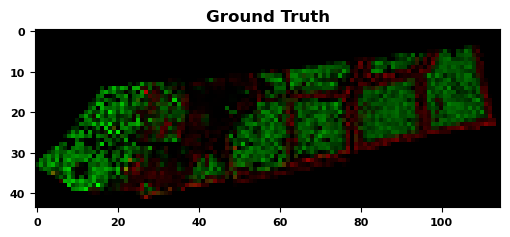

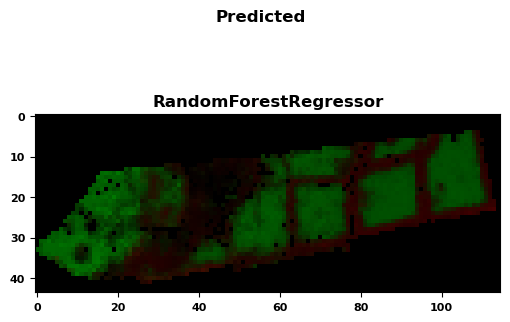

In [4]:
from ltm.models import cv_predict

orig_plot, pred_plots = cv_predict(
    search_results,
    X_path,
    y_path,
    # rgb_bands=None,
    kfold_from_endmembers=False,
    random_state=0
)

In [ ]:
search_results[2].best_estimator_.fit(X_train, y_train)

In [ ]:
predicted_y = search_results[2].best_estimator_.predict(X_test)

In [ ]:
broadleaf = y_test[:, 0]
conifer = y_test[:, 1]
broadleaf_share_test = broadleaf / (broadleaf + conifer)

broadleaf = np.maximum(predicted_y[:, 0], 0)
conifer = np.maximum(predicted_y[:, 1], 0)
broadleaf_share_pred = broadleaf / (broadleaf + conifer)

In [ ]:
broadleaf_share_pred = predicted_y
broadleaf_share_test = y_test

In [ ]:
coefficient_of_dermination = r2_score(broadleaf_share_test, broadleaf_share_pred)

In [ ]:
coefficient_of_dermination  # 0.5776951683455496

In [ ]:
mean_squared_error(broadleaf_share_test, broadleaf_share_pred)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(broadleaf_share_test, broadleaf_share_pred, "o", alpha=0.1)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test, predicted_y, "o", alpha=0.1)
# plt.plot(y_test[:, 1], predicted_y[:, 1], "o", alpha=0.1)
# plt.plot(broadleaf_share_test, broadleaf_share_pred, "o", alpha=0.1)

In [ ]:
# Plot original and predicted values, one plot per prediction
for pred_plot, results in zip(pred_plots, search_results):
    x = orig_plot.flatten()
    y = pred_plot.flatten()
    plt.plot(x, y, ".", alpha=0.1)
    plt.xlabel("Original")
    plt.ylabel(results.best_estimator_.__class__.__name__)
    plt.show()

In [ ]:
# Impurity based feature importance (bad if high cardinality features with many unique values are present)
import numpy as np

forest = search_results[2].best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

import pandas as pd

forest_importances = pd.Series(importances, index=band_names)

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# Permutation importance
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

result = permutation_importance(
    regressor, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=band_names)
forest_importances = forest_importances[forest_importances >= threshold]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean score decrease")
fig.tight_layout()
plt.show()